In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

!cp "/content/gdrive/My Drive/PyTorch/utils/torch_wrapper.py" "/content"
from torch_wrapper import TorchWrapper
!cp "/content/gdrive/My Drive/PyTorch/utils/utils.py" "/content"
import utils
%load_ext autoreload
%autoreload 2

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


# Pre-Process Dataset

In [2]:
# Read in 100k GC decks data
df = pd.read_csv('/content/gdrive/My Drive/PyTorch/Clash Royale/data/gc-data-2020.04-100000.csv')
for i in range(1,9):
    df['card'+str(i)] = df['card'+str(i)].apply(lambda x: x.replace('-', ' ').title().replace('Pekka', 'P.E.K.K.A').replace('X Bow', 'X-Bow'))
decks = np.array([d for d in df.values[:,1:] if 'Heal' not in d])
print(decks.shape)

# Create card look up dictionary
all_cards = set(decks.flatten())
card2ind = pickle.loads(open('/content/gdrive/My Drive/PyTorch/Clash Royale/data/2020_09_06_card2ind.p', 'rb').read())
# card2ind = dict(zip(all_cards, range(len(all_cards))))
ind2card = {v:k for k,v in card2ind.items()}

# Helper function
def one_hot_encode(deck):
  ohe_deck = np.zeros(len(card2ind))
  for card in deck:
    ohe_deck[card2ind[card]] = 1
  return ohe_deck

(100000, 8)


In [3]:
# Create dataset
# For each deck, remove each of the cards

from tqdm import tqdm

used_decks = []
seven_card_decks_str, seven_card_decks_ohe = [], []
target_cards_str, target_cards_ohe = [], []
for deck in tqdm(decks):
  for i in range(len(deck)):
    deck = list(deck)
    removed_card = deck[i]
      
    if str(sorted(deck)+[removed_card]) not in used_decks:
      used_decks.append(str(sorted(deck)+[removed_card]))
    else:
      continue

    deck_ = [d for d in deck if d != removed_card]
    seven_card_decks_str.append(deck_)
    seven_card_decks_ohe.append(one_hot_encode(deck_))
    target_cards_str.append(removed_card)
    target_cards_ohe.append(one_hot_encode([removed_card]))
  

seven_card_decks_str = np.array(seven_card_decks_str)
seven_card_decks_ohe = np.array(seven_card_decks_ohe)
target_cards_str = np.array(target_cards_str)
target_cards_ohe = np.array(target_cards_ohe)

seven_card_decks_ohe.shape, target_cards_ohe.shape

100%|██████████| 100000/100000 [02:45<00:00, 603.79it/s]


((123040, 98), (123040, 98))

# Load Data into TorchWrapper

In [4]:
class ClashDataset(Dataset):

    def __init__(self, x, y, device, transform=None):
        self.x = x
        self.y = y
        self.device = device
        self.transform = transform
      
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = torch.tensor(self.x[idx][None, None, :]).float().to(self.device)
        y = torch.tensor(np.argmax(self.y[idx])).to(self.device).unsqueeze(0)

        sample = [x,y]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
torch_wrapper = TorchWrapper(seven_card_decks_ohe, target_cards_str, 
                             ClashDataset,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(32,-1,1), num_workers=(0,0,0),
                             preprocess_data=True)

Data is split:
Training shape: ((98432, 98), (98432, 98))
Validation shape: ((12304, 98), (12304, 98))
Testing shape: ((12304, 98), (12304, 98))

Data is loaded into DataLoaders.


# Train Model

In [5]:
class LinearNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(
      nn.Linear(98, 98*3),
      nn.ReLU(inplace=True),
      nn.Linear(98*3, 98*2),
      nn.ReLU(inplace=True),
      nn.Linear(98*2, 98*1)
    )

  def forward(self, x):
    x = x.view(-1, 98*1)
    x = self.classifier(x)
    return x

In [ ]:
torch_wrapper.load_net(net=LinearNet(), weights='equal', 
                       chosen_criterion=nn.CrossEntropyLoss, 
                       chosen_optimizer=optim.Adam,
                       chosen_optimizer_params={'lr':0.001, 'betas':(0.9, 0.999), 'eps':1e-08, 'weight_decay':0, 'amsgrad':False})


Network is loaded.



[1,  2000] train_loss: 3.430 | val_loss: 3.042
[2,  2000] train_loss: 4.459 | val_loss: 2.863
[3,  2000] train_loss: 4.206 | val_loss: 2.792
[4,  2000] train_loss: 4.035 | val_loss: 2.740
[5,  2000] train_loss: 3.895 | val_loss: 2.709
[6,  2000] train_loss: 3.763 | val_loss: 2.692
[7,  2000] train_loss: 3.642 | val_loss: 2.694
[8,  2000] train_loss: 3.554 | val_loss: 2.702
[9,  2000] train_loss: 3.449 | val_loss: 2.696
[10,  2000] train_loss: 3.364 | val_loss: 2.701


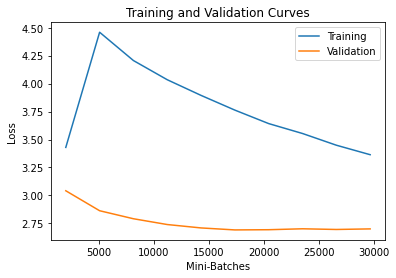

Finished Training


In [ ]:
torch_wrapper.train(epochs=10,
                    models_dir='/content/gdrive/My Drive/PyTorch/Clash Royale/model_checkpoints')

# Load Model

Loaded epoch10_model.pt in eval mode.



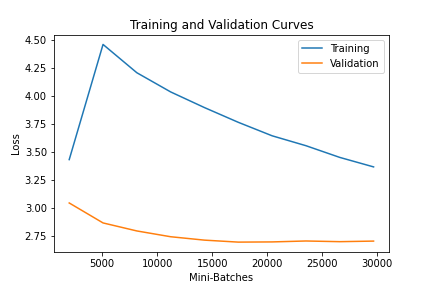

Data is split:
Training shape: ((98432, 98), (98432, 98))
Validation shape: ((12304, 98), (12304, 98))
Testing shape: ((12304, 98), (12304, 98))

Data is loaded into DataLoaders.


In [13]:
net = LinearNet()

torch_wrapper = TorchWrapper(seven_card_decks_ohe, target_cards_str, 
                             ClashDataset,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(-1,-1,-1), num_workers=(0,0,0),
                             preprocess_data=False)

torch_wrapper.load_checkpoint(net,
                              checkpoints_path='/content/gdrive/My Drive/PyTorch/Clash Royale/model_checkpoints/20201107T203833_models/',
                              model_name='epoch10_model.pt', load_type='eval')

# Evaluate Model

  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating Train set...


/content/torch_wrapper.py:265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = self.net(torch.tensor(inputs).float().to(self.device)).cpu().detach()
  0%|          | 0/1 [00:00<?, ?it/s]


Average Train Accuracy: 46.89%
Average Train Hit@N: 4.4

Evaluating Validation set...


  0%|          | 0/1 [00:00<?, ?it/s]


Average Validation Accuracy: 34.09%
Average Validation Hit@N: 8.4

Evaluating Test set...


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]



Average Test Accuracy: 34.29%
Average Test Hit@N: 8.1



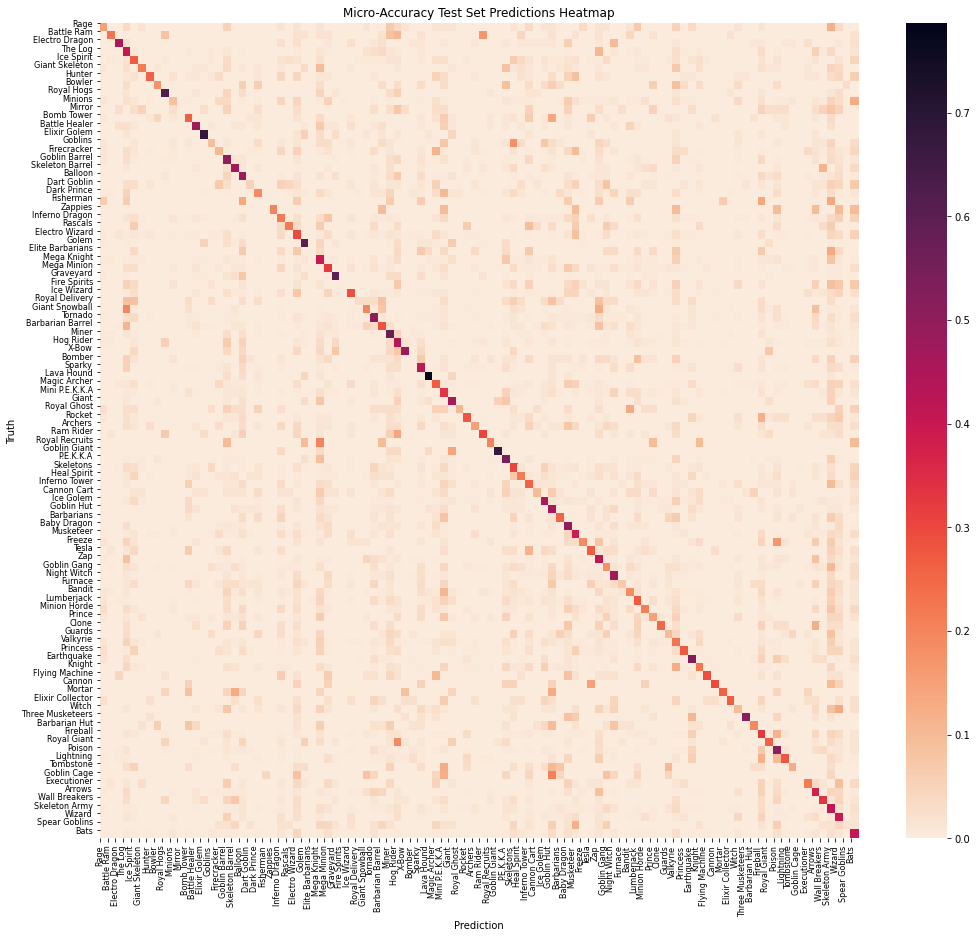

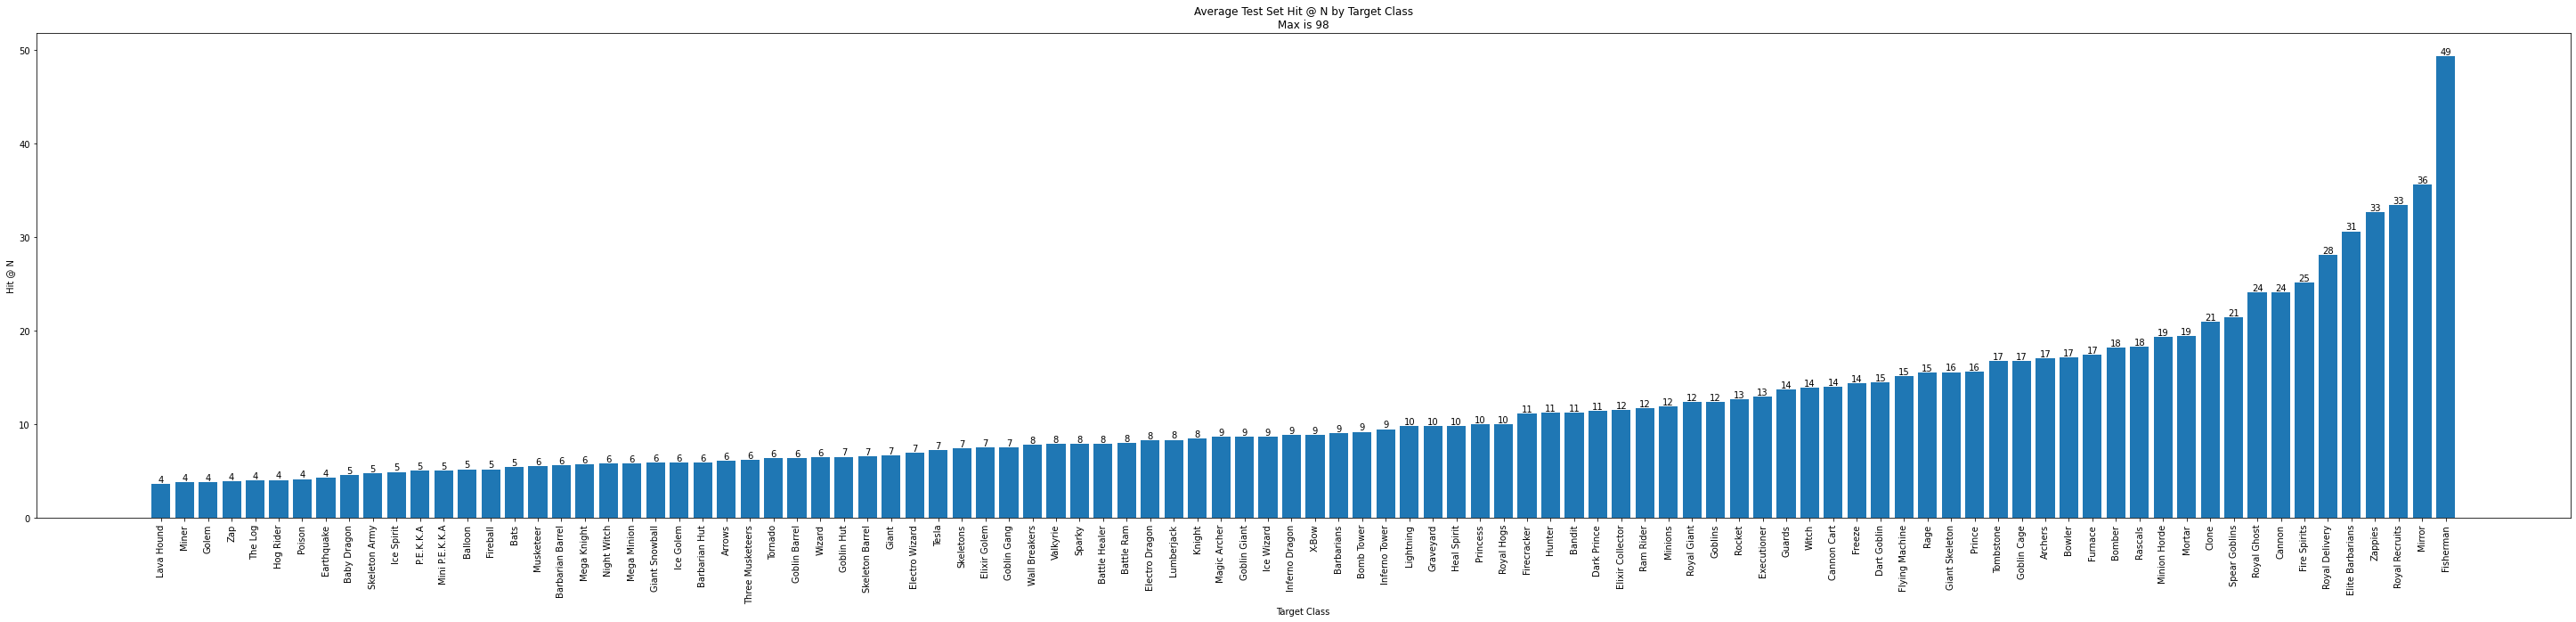

In [23]:
torch_wrapper.evaluate()

# Use Model to Build Decks

In [24]:
# Get original training decks for testing novelty of decks created
train_decks = [x+[y] for x,y in \
               zip(seven_card_decks_str[torch_wrapper.train_inds].tolist(), 
                   target_cards_str[torch_wrapper.train_inds].tolist())]

In [28]:
# Iteratively create a deck given inputs (beam search)
# (https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)

from operator import itemgetter

k = 3
input_decks = [[['Miner'], 1]]

for i in range(8-len(input_decks[0][0])):
  replace_input_decks = []
  used_decks = []
  for deck in input_decks:
    ohe_deck = one_hot_encode(deck[0])
    probs = torch_wrapper.predict(ohe_deck, softmax=True)
    preds = np.argsort(probs)[::-1]
    count = 0
    for p in preds:
      new_deck = deepcopy(deck)
      pred_card = torch_wrapper.ind2target[p]
      pred_prob = probs[p]
      if pred_card not in deck[0]:
        new_deck[0].extend([pred_card])
        if sorted(new_deck[0]) not in used_decks:
          count += 1
          used_decks.append(sorted(new_deck[0]))
          new_deck[1] = new_deck[1]*pred_prob
          replace_input_decks.append(new_deck)
          if count == k:
            break
  input_decks = replace_input_decks
        
print(len(input_decks))
for deck_ in sorted(input_decks, key=itemgetter(1), reverse=True)[:10]:
  print(deck_)
  # print(Counter([True if sorted(deck_[0])==sorted(d) else False for d in train_decks])) # This makes it very slow
  # print()

2187
[['Miner', 'Bats', 'Goblin Gang', 'Inferno Dragon', 'Giant Snowball', 'Mega Knight', 'Skeleton Barrel', 'Goblin Hut'], 4.013882624559763e-05]
[['Miner', 'Bats', 'Wall Breakers', 'Bomb Tower', 'Arrows', 'Valkyrie', 'Magic Archer', 'Skeletons'], 3.143924103617157e-05]
[['Miner', 'Bats', 'Wall Breakers', 'Bomb Tower', 'Giant Snowball', 'Skeletons', 'Magic Archer', 'Valkyrie'], 2.2183005509785134e-05]
[['Miner', 'Bats', 'Wall Breakers', 'Bomb Tower', 'Giant Snowball', 'Goblins', 'Magic Archer', 'Valkyrie'], 1.690492415114932e-05]
[['Miner', 'Bats', 'Wall Breakers', 'Bomb Tower', 'Giant Snowball', 'Skeletons', 'Poison', 'Valkyrie'], 1.6247693559101178e-05]
[['Miner', 'Bats', 'Wall Breakers', 'Bomb Tower', 'Arrows', 'Valkyrie', 'Magic Archer', 'Goblins'], 1.6156826279716085e-05]
[['Miner', 'Mega Minion', 'Arrows', 'Lava Hound', 'Barbarians', 'Baby Dragon', 'Flying Machine', 'Goblin Hut'], 1.526884951205453e-05]
[['Miner', 'Mega Minion', 'Fireball', 'Lava Hound', 'Zap', 'Baby Dragon', 'B

In [29]:
# Check predictions given inputs
input_deck = ['Miner']
ohe_deck = one_hot_encode(input_deck)

outputs = torch_wrapper.predict(ohe_deck)
preds = np.argsort(outputs[0])[::-1][:5]

print('Find cards for: {}'.format(input_deck))
print('Predictions: {}'.format(', '.join([torch_wrapper.ind2target[p] for p in preds])))

Find cards for: ['Miner']
Predictions: Bats, Baby Dragon, Mega Minion, Firecracker, Electro Dragon


In [32]:
# Make a deck one card at a time based on user input

from IPython.display import HTML-

card_images_dict = pickle.loads(open('/content/gdrive/My Drive/PyTorch/Clash Royale/data/2020_11_07_card_images_dict.p', 'rb').read())
def show_deck(deck):
  html_decks = ''.join([f"""<img src="{card_images_dict[card]}" style="height:100px;"/>""" for card in deck])
  display(HTML(f"""<table><tr><td>{html_decks}</td></tr></table>"""))

input_cards_str = input("What cards are you starting with? ")
input_deck = [d.strip() for d in input_cards_str.split(',')]
for card in input_deck:
  if card_images_dict.get(card) is None:
    raise ValueError(f"{card} is not an acceptable input. Try again.")
print('Your deck:')
show_deck(input_deck)
while len(input_deck) < 8:
  ohe_deck = one_hot_encode(input_deck)
  outputs = torch_wrapper.predict(ohe_deck)
  preds = np.argsort(outputs[0])[::-1]
  available_cards = [torch_wrapper.ind2target[p] for p in preds if torch_wrapper.ind2target[p] not in input_decks][:10]
  print('Top 10 suggested cards:')
  show_deck(available_cards)
  added_card = input("Which card do you want to add? ")
  if card_images_dict.get(added_card) is None:
    raise ValueError(f"{added_card} is not an acceptable input. Try again.")
  input_deck.append(added_card)
  print('Your deck:')
  show_deck(input_deck)
  print('*'*50)

What cards are you starting with? Royal Giant
Your deck:


""


Top 10 suggested cards:


""


Which card do you want to add? Sparky
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Firecracker
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Zap
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Valkyrie
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Electro Wizard
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Arrows
Your deck:


""


**************************************************
Top 10 suggested cards:


""


Which card do you want to add? Mini P.E.K.K.A
Your deck:


""


**************************************************
